In [63]:

# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
import scipy.stats as stats

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")


from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind

In [64]:
# VAMOS A VER ALGUNOS MÉTODOS DE VISUALIZACIÓN QUE NO CONOCIAMOS:

# establece el estilo del fondo de las gráficas como "whitegrid". Las gráficas tendrán un fondo blanco con líneas de cuadrícula horizontales y verticales.
sns.set_style("whitegrid")

# cambiará el esquema de colores predeterminado de Seaborn a uno más oscuro, adecuado para gráficas con fondos claros. 
sns.set_theme(style="dark")

# establece el estilo en Solarize_Lihgt2. 
plt.style.use('Solarize_Light2')

In [65]:
df = pd.read_csv("marketing_AB.csv", index_col = 0)
df.sample(10)

,user id,test group,converted,total ads,most ads day,most ads hour
48312,1405394,ad,False,6,Thursday,8
223448,1027924,ad,False,42,Saturday,13
91021,1184040,ad,False,23,Wednesday,9
582160,1564684,ad,False,1,Monday,15
50949,917398,psa,False,175,Thursday,11
56326,1363606,ad,False,44,Monday,11
331219,1099248,ad,False,4,Thursday,10
111795,1535898,ad,False,22,Friday,19
235961,1522342,ad,False,33,Saturday,12
170012,1463161,ad,False,89,Friday,21


Ejercicio 1: Supongamos que estamos realizando un experimento para determinar si un nuevo diseño de anuncio (test group "ad") tiene un impacto significativo en la tasa de conversión en comparación con el diseño de anuncio anterior (test group "psa").

- Objetivo del ejercicio: Comparar las tasas de conversión entre los grupos de prueba "ad" y "psa" para determinar si el nuevo diseño de anuncio es más efectivo en la conversión de usuarios.

Pasos que debemos seguir:

Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

In [66]:
# una vez que tengamos nuestro DataFrame preparado con todas las columnas que queremos vamos a crear una función que no haga una exploración inicial del conjunto de datos
def exploracion_dataframe(df, columna_user):

    
    print(f"Los duplicados que tenemos en el conjunto de datos son: {df.duplicated().sum()}")
    print("\n ..................... \n")
    
    

    print("Los nulos que tenemos en el conjunto de datos son:")
    df_nulos = pd.DataFrame(df.isnull().sum() / df.shape[0] * 100, columns = ["%_nulos"])
    display(df_nulos[df_nulos["%_nulos"] > 0])
    
    print("\n ..................... \n")
    print(f"Los tipos de las columnas son:")
    display(pd.DataFrame(df.dtypes, columns = ["tipo_dato"]))
    
    
    print("\n ..................... \n")
    print("Los valores que tenemos para las columnas categóricas son: ")
    dataframe_categoricas = df.select_dtypes(include = "O")

    for col in dataframe_categoricas.columns:
        print(f"La columna {col.upper()} tiene las siguientes valore únicos:")
        display(pd.DataFrame(df[col].value_counts()).head())    
    
    
    for categoria in df[columna_user].unique():
        
        dataframe_filtrado = df[df[columna_user] == categoria]
    
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas categóricas para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe(include = "O").T)
        
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas numéricas para el {categoria.upper()} son: ")
        display(dataframe_filtrado.describe().T)

In [67]:
exploracion_dataframe(df,"test group")

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


,%_nulos



 ..................... 

Los tipos de las columnas son:


,tipo_dato
user id,int64
test group,object
converted,bool
total ads,int64
most ads day,object
most ads hour,int64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna TEST GROUP tiene las siguientes valore únicos:


,test group
ad,564577
psa,23524


La columna MOST ADS DAY tiene las siguientes valore únicos:


,most ads day
Friday,92608
Monday,87073
Sunday,85391
Thursday,82982
Saturday,81660



 ..................... 

Los principales estadísticos de las columnas categóricas para el AD son: 


,count,unique,top,freq
test group,564577,1,ad,564577
most ads day,564577,7,Friday,88805



 ..................... 

Los principales estadísticos de las columnas numéricas para el AD son: 


,count,mean,std,min,25%,50%,75%,max
user id,564577.0,1.327314e+06,188918.061566,1000000.0,1163686.0,1327362.0,1490914.0,1654483.0
total ads,564577.0,2.482337e+01,43.750456,1.0,4.0,13.0,27.0,2065.0
most ads hour,564577.0,1.447590e+01,4.841808,0.0,11.0,14.0,18.0,23.0



 ..................... 

Los principales estadísticos de las columnas categóricas para el PSA son: 


,count,unique,top,freq
test group,23524,1,psa,23524
most ads day,23524,7,Thursday,3905



 ..................... 

Los principales estadísticos de las columnas numéricas para el PSA son: 


,count,mean,std,min,25%,50%,75%,max
user id,23524.0,911761.500000,6790.938202,900000.0,905880.75,911761.5,917642.25,923523.0
total ads,23524.0,24.761138,42.860720,1.0,4.00,12.0,26.00,907.0
most ads hour,23524.0,14.304923,4.656239,0.0,11.00,14.0,18.00,23.0


. Definición de las hipótesis: Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento (en este caso os las damos definidas):

- Hipótesis nula (H0): No hay diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".
- Hipótesis alternativa (H1): Existe una diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

. Cálculo de la tasa de conversión: Calcula la tasa de conversión para cada grupo:

- Para el grupo "ad", la tasa de conversión es el número de usuarios convertidos dividido por el número total de usuarios en ese grupo.
- Para el grupo "psa", realiza el mismo cálculo.

In [68]:
df.sample(10)

,user id,test group,converted,total ads,most ads day,most ads hour
552283,1304046,ad,False,2,Tuesday,13
111986,1400960,ad,False,16,Sunday,18
391264,1031126,ad,False,12,Saturday,14
108942,1341881,ad,False,19,Monday,17
500219,1091747,ad,False,5,Saturday,13
312204,1515702,ad,False,16,Sunday,17
348749,1277281,ad,False,6,Monday,22
250422,1243660,ad,False,14,Friday,22
329014,1526002,ad,False,26,Friday,2
256303,1021478,ad,False,11,Wednesday,15


In [69]:
ad = df[df['test group'] == 'ad']
convert_ad = ad[ad['converted'] == True]
total_ad = ad.shape[0]
total_convertidos_ad = convert_ad.shape[0]

In [70]:
tasa_conversion_ad = total_convertidos_ad / total_ad
round(tasa_conversion_ad,2 )

0.03

In [71]:
psa = df[df['test group'] == 'psa']
convert_psa = psa[psa['converted'] == True]
total_psa = psa.shape[0]
total_convertidos_psa = convert_psa.shape[0]


In [72]:
tasa_conversion_psa = total_convertidos_psa / total_psa
round(tasa_conversion_psa,2)

0.02

In [78]:

df['tasa_conversion'] = df.apply( lambda x: tasa_conversion_ad if x['test group'] == 'ad' else tasa_conversion_psa, axis=1)
df.sample(10)


,user id,test group,converted,total ads,most ads day,most ads hour,tasa_conversion
371045,1638302,ad,False,45,Tuesday,8,0.025547
487264,1297195,ad,False,8,Thursday,20,0.025547
310453,906621,psa,False,18,Sunday,13,0.017854
571336,1156896,ad,False,6,Friday,23,0.025547
42102,1028668,ad,False,77,Saturday,7,0.025547
182589,1213000,ad,False,65,Saturday,14,0.025547
229572,1294369,ad,False,6,Saturday,13,0.025547
66355,1438428,ad,False,7,Wednesday,13,0.025547
521392,1341765,ad,False,25,Thursday,18,0.025547
55240,1366723,ad,False,113,Friday,15,0.025547


Prueba de hipótesis: Utiliza una prueba estadística, como la prueba t de Student o la prueba chi-cuadrado, para comparar las tasas de conversión entre los grupos "ad" y "psa".

In [76]:
contingency = pd.crosstab(df['test group'], df['tasa_conversion'])
chi2, p_chi2, _, _ = chi2_contingency(contingency)
print(f"Prueba de Chi-cuadrado - p-valor: {p_chi2}")

Prueba de Chi-cuadrado - p-valor: 0.0


In [77]:
grupos = df[df['test group'] == 'ad']
test_group = df[df['test group'] == 'Test ad']
t_stat, p_ttest = ttest_ind(grupos['tasa_conversion'], test_group['tasa_conversion'])
print(f"Prueba t para CTR entre Control y Test - p-valor: {p_ttest}")

Prueba t para CTR entre Control y Test - p-valor: nan


En este caso, vamos a realizar un experimento para comparar la cantidad promedio de anuncios vistos por los usuarios en los grupos "ad" y "psa" y determinar si hay una diferencia significativa entre ellos.

Objetivo del experimento: Comparar la cantidad promedio de anuncios vistos por usuario entre los grupos de prueba "ad" y "psa" para determinar si el tipo de anuncio afecta la cantidad de anuncios que los usuarios ven.

Preparación de los datos: Asegúrate de que los datos estén limpios y listos para el análisis. Esto incluye la eliminación de datos faltantes y la verificación de la coherencia de los datos.

Hipótesis: Plantea una hipótesis nula (H0) y una hipótesis alternativa (H1) para el experimento. En este caso, las deberéis plantear vosotras
Prueba de hipótesis: Utiliza una prueba estadística, como la prueba t de Student, para comparar la cantidad promedio de anuncios vistos por usuario entre los grupos "ad" y "psa". Esto te permitirá determinar si hay una diferencia significativa entre los dos grupos.

Análisis de resultados:
Si el valor p (p-value) es menor que un umbral predefinido (por ejemplo, 0.05), rechazamos la hipótesis nula y concluimos que hay una diferencia significativa en la cantidad promedio de anuncios vistos por usuario entre los grupos.

Si el valor p es mayor que el umbral, no podemos rechazar la hipótesis nula y concluimos que no hay evidencia suficiente para afirmar que hay una diferencia significativa.

Conclusiones y recomendaciones: Basándote en los resultados de la prueba de hipótesis, llega a una conclusión sobre si el tipo de anuncio (ad o psa) tiene un impacto significativo en la cantidad promedio de anuncios vistos por usuario. Si es así, puedes hacer recomendaciones basadas en estos hallazgos.

In [ ]:
#Hipótesis nula (H0): No hay diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".
#Hipótesis alternativa (H1): Existe una diferencia significativa en la tasa de conversión entre los grupos de prueba "ad" y "psa".

In [ ]:

# importamos las librerías que necesitamos

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualización
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# Evaluar linealidad de las relaciones entre las variables
# y la distribución de las variables
# ------------------------------------------------------------------------------
from scipy.stats import shapiro, kstest

import scipy.stats as stats

# Gestión de los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")


# -----------------------------------------------------------------------
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import levene

# Configuración
# -----------------------------------------------------------------------
pd.set_option('display.max_columns', None) # para poder visualizar todas las columnas de los DataFrames


In [ ]:

# establece el estilo del fondo de las gráficas como "whitegrid". Las gráficas tendrán un fondo blanco con líneas de cuadrícula horizontales y verticales.
sns.set_style("whitegrid")

# cambiará el esquema de colores predeterminado de Seaborn a uno más oscuro, adecuado para gráficas con fondos claros. 
sns.set_theme(style="dark")

# establece el estilo en Solarize_Lihgt2. 
plt.style.use('Solarize_Light2')

In [ ]:
df = pd.read_csv("marketing_AB.csv", index_col = 0)
df.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [ ]:
#henos quitado los espacios en el nm de las columnas
columnas = [col.replace(" ", "_") for col in df.columns]
df.columns = columnas

In [ ]:
df.columns

Index(['user_id', 'test_group', 'converted', 'total_ads', 'most_ads_day',
       'most_ads_hour'],
      dtype='object')

In [ ]:
#para hacer los calculos vemos cuantos users hay de cada test group
df["test_group"].value_counts() #psa es control y ad es test

ad     564577
psa     23524
Name: test_group, dtype: int64

In [ ]:
def exploracion_dataframe(dataframe, columna_control):
    
    print(f"Los duplicados que tenemos en el conjunto de datos son: {df.duplicated().sum()}")
    print("\n ..................... \n")
    
    

    print("Los nulos que tenemos en el conjunto de datos son:")
    df_nulos = pd.DataFrame(df.isnull().sum() / df.shape[0] * 100, columns = ["%_nulos"])
    display(df_nulos["%_nulos"])
    
    print("\n ..................... \n")
    print(f"Los tipos de las columnas son:")
    display(pd.DataFrame(df.dtypes, columns = ["tipo_dato"]))
    
    
    print("\n ..................... \n")
    print("Los valores que tenemos para las columnas categóricas son: ")
    dataframe_categoricas = df.select_dtypes(include = "O")
    
    for col in dataframe_categoricas.columns:
        print(f"La columna {col} tiene las siguientes valore únicos:")
        display(pd.DataFrame(df[col].value_counts()).head())    
    
    # como estamos en un problema de A/B testing y lo que realmente nos importa es comparar entre el grupo de control y el de test, 
    # los principales estadísticos los vamos a sacar de cada una de las categorías
    
    for categoria in dataframe[columna_control].unique():
        
        dataframe_filtrado = dataframe[dataframe[columna_control] == categoria]
    
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas categóricas para el {categoria} son: ")
        display(dataframe_filtrado.describe(include = "O").T)
        
        print("\n ..................... \n")
        print(f"Los principales estadísticos de las columnas numéricas para el {categoria} son: ")
        display(dataframe_filtrado.describe().T)

In [ ]:
exploracion_dataframe(df,"test_group")

Los duplicados que tenemos en el conjunto de datos son: 0

 ..................... 

Los nulos que tenemos en el conjunto de datos son:


user_id          0.0
test_group       0.0
converted        0.0
total_ads        0.0
most_ads_day     0.0
most_ads_hour    0.0
Name: %_nulos, dtype: float64


 ..................... 

Los tipos de las columnas son:


,tipo_dato
user_id,int64
test_group,object
converted,bool
total_ads,int64
most_ads_day,object
most_ads_hour,int64



 ..................... 

Los valores que tenemos para las columnas categóricas son: 
La columna test_group tiene las siguientes valore únicos:


,test_group
ad,564577
psa,23524


La columna most_ads_day tiene las siguientes valore únicos:


,most_ads_day
Friday,92608
Monday,87073
Sunday,85391
Thursday,82982
Saturday,81660



 ..................... 

Los principales estadísticos de las columnas categóricas para el ad son: 


,count,unique,top,freq
test_group,564577,1,ad,564577
most_ads_day,564577,7,Friday,88805



 ..................... 

Los principales estadísticos de las columnas numéricas para el ad son: 


,count,mean,std,min,25%,50%,75%,max
user_id,564577.0,1.327314e+06,188918.061566,1000000.0,1163686.0,1327362.0,1490914.0,1654483.0
total_ads,564577.0,2.482337e+01,43.750456,1.0,4.0,13.0,27.0,2065.0
most_ads_hour,564577.0,1.447590e+01,4.841808,0.0,11.0,14.0,18.0,23.0



 ..................... 

Los principales estadísticos de las columnas categóricas para el psa son: 


,count,unique,top,freq
test_group,23524,1,psa,23524
most_ads_day,23524,7,Thursday,3905



 ..................... 

Los principales estadísticos de las columnas numéricas para el psa son: 


,count,mean,std,min,25%,50%,75%,max
user_id,23524.0,911761.500000,6790.938202,900000.0,905880.75,911761.5,917642.25,923523.0
total_ads,23524.0,24.761138,42.860720,1.0,4.00,12.0,26.00,907.0
most_ads_hour,23524.0,14.304923,4.656239,0.0,11.00,14.0,18.00,23.0


In [ ]:

# calculamos la Tasa de Conversión
df['CR'] = df['converted'] / df['total_ads']

# mostramos el DataFrame para confirmar que todo ha ido bien. 
df.head()

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour,CR
0,1069124,ad,False,130,Monday,20,0.0
1,1119715,ad,False,93,Tuesday,22,0.0
2,1144181,ad,False,21,Tuesday,18,0.0
3,1435133,ad,False,355,Tuesday,10,0.0
4,1015700,ad,False,276,Friday,14,0.0


Text(0.5, 1.0, 'Tasa de Conversión')

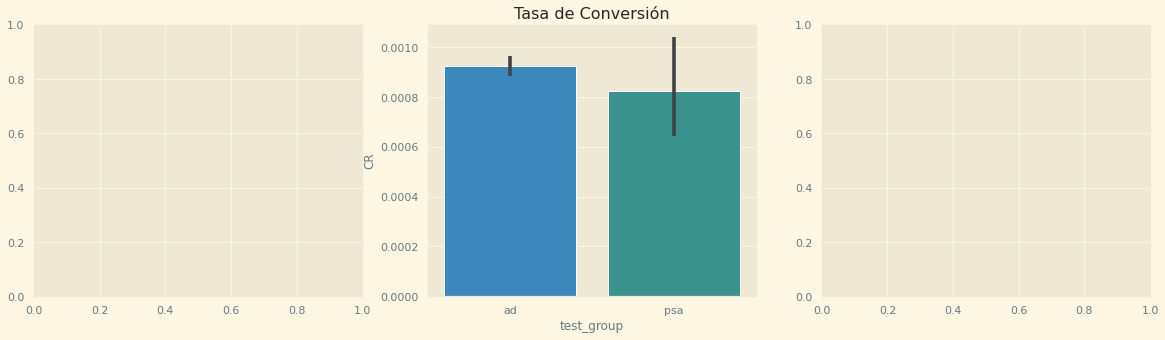

In [ ]:
#en este paso tendriamos que crear 3 subgraficos pero solo tenemos datos para calcular la CR

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

#Tasa de Conversión (CR)
sns.barplot(x="test_group", y="CR", data=df, ax=axes[1])
axes[1].set_title("Tasa de Conversión")


<AxesSubplot:xlabel='test_group', ylabel='CR'>

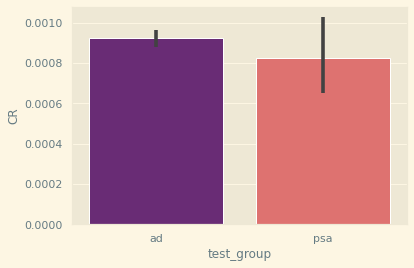

In [ ]:
sns.barplot(x = "test_group", 
            y = "CR", 
            data = df, 
            palette = "magma")

In [ ]:
statistic, p_value = stats.shapiro(df["CR"])
if p_value > 0.05:
    print("Para la columna CR los datos siguen una distribución normal.")
else:
    print("Para la columna CR los datos no siguen una distribución normal.")

Para la columna CR los datos no siguen una distribución normal.


In [ ]:

def homogeneidad (dataframe, columna, columna_metrica):
    
    """
    Evalúa la homogeneidad de las varianzas entre grupos para una métrica específica en un DataFrame dado.

    Parámetros:
    - dataframe (DataFrame): El DataFrame que contiene los datos.
    - columna (str): El nombre de la columna que se utilizará para dividir los datos en grupos.
    - columna_metrica (str): El nombre de la columna que se utilizará para evaluar la homogeneidad de las varianzas.

    Returns:
    No devuelve nada directamente, pero imprime en la consola si las varianzas son homogéneas o no entre los grupos.
    Se utiliza la prueba de Levene para evaluar la homogeneidad de las varianzas. Si el valor p resultante es mayor que 0.05,
    se concluye que las varianzas son homogéneas; de lo contrario, se concluye que las varianzas no son homogéneas.
    """
    
    # lo primero que tenemos que hacer es crear tantos conjuntos de datos para cada una de las categorías que tenemos, Control Campaign y Test Campaign
    valores_evaluar = []
    
    for valor in dataframe[columna].unique():
        valores_evaluar.append(dataframe[dataframe[columna]== valor][columna_metrica])

    statistic, p_value = stats.levene(*valores_evaluar)
    if p_value > 0.05:
        print(f"Para la métrica {columna_metrica} las varianzas son homogéneas entre grupos.")
    else:
        print(f"Para la métrica {columna_metrica}, las varianzas no son homogéneas entre grupos.")


In [ ]:
homogeneidad(df ,'test_group', "CR")

Para la métrica CR las varianzas son homogéneas entre grupos.


In [ ]:
df_media = df.groupby('test_group')['total_ads'].mean().reset_index()
df_media

,test_group,total_ads
0,ad,24.823365
1,psa,24.761138


In [ ]:
psa_group_t = df_media[df_media['test_group'] == 'psa']['total_ads']
ad_group_t = df_media[df_media['test_group'] == 'ad']['total_ads']


t_stat, p_value = ttest_ind(psa_group_t, ad_group_t)

# Imprimir el resultado de la prueba
if p_value < 0.05:
    print("Hay una diferencia significativa en el promedio de anuncios vistos  entre el grupo ad y el grupo psa.")
    print("\n ---------- \n")
    print("""
          Los resultados sugieren que existe evidencia estadística para afirmar que las medias de las muestras son distintas. 
          Por lo tanto, nuestro nuevo sistema tiene los efectos deseados y deberíamos cambiar la nueva versión de anuncios   
          """)
else:
    print("No hay evidencia de una diferencia significativa en el promedio de anuncios vistos entre los grupos.")
    print("\n ---------- \n")
    print("""
          Los resultados sugieren que no existe evidencia estadística para afirmar que las medias de las muestras son distintas. 
          el análisis estadístico nos sugiera que estas diferencias no son significativas, 
          por lo que la nueva campaña no esta ayudando a nuestro problema.   
          """)


No hay evidencia de una diferencia significativa en el promedio de anuncios vistos entre los grupos.

 ---------- 


          Los resultados sugieren que no existe evidencia estadística para afirmar que las medias de las muestras son distintas. 
          el análisis estadístico nos sugiera que estas diferencias no son significativas, 
          por lo que la nueva campaña no esta ayudando a nuestro problema.   
          
